# EX_11  어제 오른 내 주식, 과연 내일은?

## 목표: 주식 예측에 도전해 보자

### lubric

1. 시계열의 안정성이 충분히 확인되었는가? 플로팅과 adfuller 메소드가 모두 적절히 사용되었음
2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가? p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨
3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가? 3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨

### 학습 목표

- 시계열 데이터의 특성과 안정적(Stationary) 시계열의 개념을 이해한다.
- ARIMA 모델을 구성하는 AR, MA, Diffencing의 개념을 이해하고 간단한 시계열 데이터에 적용해 본다.
- 실제 주식 데이터에 ARIMA를 적용해서 예측 정확도를 확인해 본다.

### 🚩keyword

✔ 시계열분석

## start

1. 시계열 데이터 준비
2. 각종 전처리 수행
3. 시계열 안정성 분석
4. 학습, 테스트 데이터셋 생성
5. 적정 ARIMA 모수 찾기
6. ARIMA 모델 훈련과 테스트
7. 다른 주식 종목 예측해 보기

### STEP 1. 시계열 데이터 준비

- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

dataset_filepath = os.getenv('HOME')+'/aiffel/EXPLORATIONS/EX_11/stock_prediction/data/005930.KS.csv' 

# index_col=['column_name']으로 설정해주면 날짜/시간을 pandas의 DataFrame의 index로 바로 읽어올 수 있습니다.
# parse_dates=['date'] 처럼 명시적으로 칼럼 이름을 설정하는 방법도 가능
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

### STEP 2 : 각종 전처리 수행

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 250 entries, 2020-05-18 to 2021-05-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       250 non-null    float64
 1   High       250 non-null    float64
 2   Low        250 non-null    float64
 3   Close      250 non-null    float64
 4   Adj Close  250 non-null    float64
 5   Volume     250 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 13.7 KB


In [5]:
# 결측치 처리

ts = ts.interpolate(method='time') # # pandas.DataFrame.interpolate(): time 메서드를 보간
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

결측치 없음

1. 정성적인 분석을 통해 보다 안정적(starionary)인 특성을 가지도록 기존의 시계열 데이터를 가공/변형하는 시도
- 로그함수 변환
- Moving average 제거 - 추세(Trend) 상쇄하기
- 차분(Differencing) - 계절성(Seasonality) 상쇄하기

2. 시계열 분해(Time series decomposition) 기법을 적용

In [6]:
# 1-1 로그 변환 시도 
ts_log = np.log(ts)
ts_log

Date
2020-05-18    10.795486
2020-05-19    10.825760
2020-05-20    10.819778
2020-05-21    10.818778
2020-05-22    10.794460
                ...    
2021-05-12    11.289782
2021-05-13    11.270854
2021-05-14    11.291031
2021-05-17    11.284769
2021-05-18    11.284769
Name: Close, Length: 250, dtype: float64

시계열 분석에서 위와 같이 시간 추이에 따라 나타나는 평균값 변화를 추세(trend)라고 합니다. 이 변화량을 제거해 주려면 거꾸로 Moving Average, 즉 rolling mean을 구해서 ts_log에서 빼주면 어떨까요?

In [7]:
# 1-2. Moving average 제거 - 추세(Trend) 상쇄하기

moving_avg = ts_log.rolling(window=12).mean()  # moving average구하기 
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20         NaN
2020-05-21         NaN
2020-05-22         NaN
2020-05-25         NaN
2020-05-26         NaN
2020-05-27         NaN
2020-05-28         NaN
2020-05-29         NaN
2020-06-01         NaN
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
Name: Close, dtype: float64

우리가 관심을 가진 ts_log_moving_avg에 거의 도달했습니다. 그런데 문제는 Moving Average 계산 시 (windows size=12인 경우) 앞의 11개의 데이터는 Moving Average가 계산되지 않으므로 ts_log_moving_avg에 결측치(NaN)가 발생한다는 점입니다.
이 결측치들은 향후 Dicky-Fuller Test 시에 에러를 발생시킬 것이므로 이를 데이터셋에서 제거해 줍니다.

In [8]:
ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2020-06-02    0.028599
2020-06-03    0.077956
2020-06-04    0.072953
2020-06-05    0.080606
2020-06-08    0.061862
2020-06-09    0.061925
2020-06-10    0.049636
2020-06-11    0.021446
2020-06-12   -0.019996
2020-06-15   -0.066141
2020-06-16   -0.025267
2020-06-17   -0.024961
2020-06-18   -0.024494
2020-06-19   -0.010603
2020-06-22   -0.023697
Name: Close, dtype: float64

In [9]:
# 1-3. 차분(Differencing) - 계절성(Seasonality) 상쇄하기

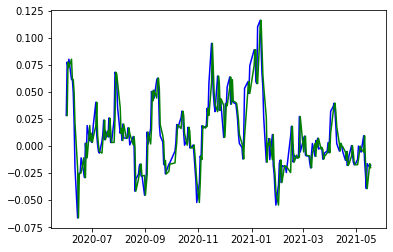

In [10]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

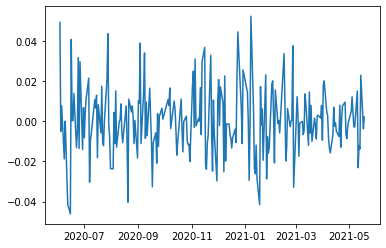

In [11]:
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff)

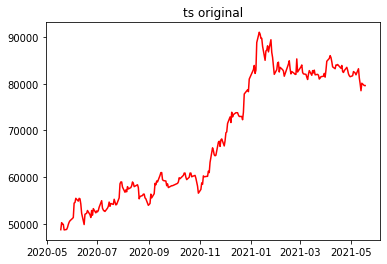

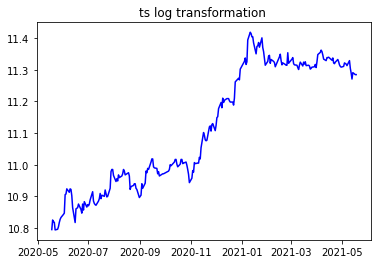

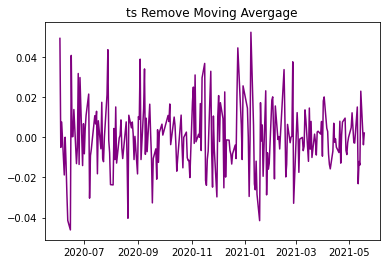

In [12]:
# ts Series
plt.plot(ts, color='red')
plt.title('ts original')
plt.show()

# 로그 변환한 ts
plt.plot(ts_log, color='blue')
plt.title('ts log transformation ')
plt.show()


# 로그변환 시계열에 Moving Average 제거
plt.plot(ts_log_moving_avg_diff, color='purple')
plt.title('ts Remove Moving Avergage')
plt.show()

### STEP 3 : 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [13]:
# 정성적 그래프 분석
# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [14]:
#정량적 Augmented Dicky-Fuller Test

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

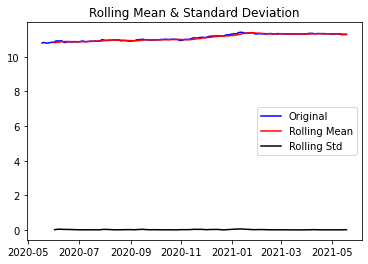

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


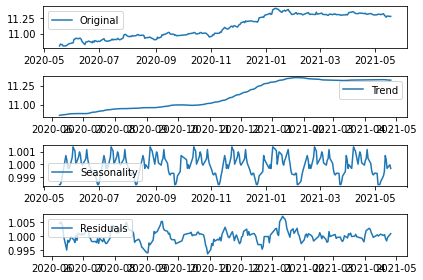

In [15]:
#시계열 분해 (Time Series Decomposition)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [16]:
# Residual 안정성 확인

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


### STEP 4 : 학습, 테스트 데이터셋 생성

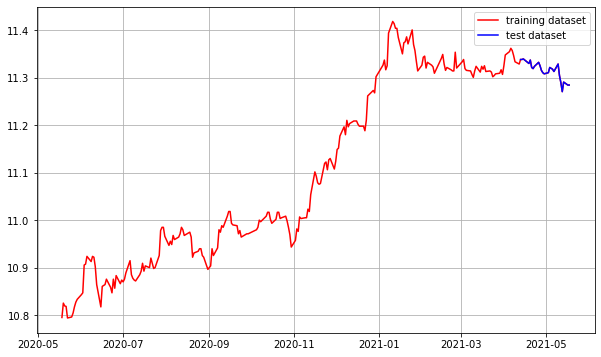

In [17]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

#### STEP 5 : 적정 ARIMA 모수 찾기

1. ACF, PACF 그려보기 -> p,q 구하기
2. 차분 안정성 확인 -> d 구하기

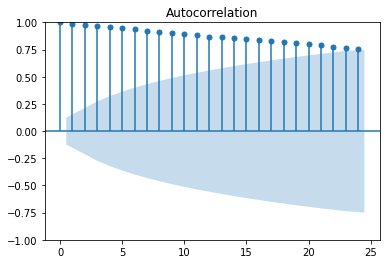

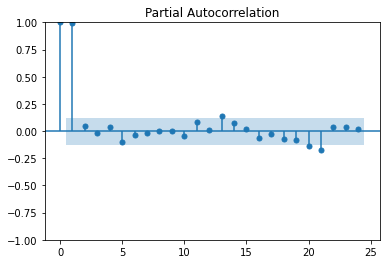

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기

plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

#### ARIMA를 효과적으로 활용하기 위해서는 ARIMA의 모수(parameter)를 잘 설정해야하는데 이게 ARIMA의 keypoint

- p : 자기회귀 모형(AR)의 시차
- q : 이동평균 모형(MA)의 시차
- d : 차분누적(I) 횟수

- p와 q는 일반적으로 p + q < 2, p * q=0인 값을 사용한다고 합니다. p와 q 중 하나는 0이라는 뜻으로 시계열 데이터가 AR이나 MA 중 하나의 경향만 가지기 때문
- ACF 그래프를 보았을 때 값은 1에서 점점 작아지고 이는 점차적으로 작아지는 AR(p) 모델과 동일. 반면에 PACF 그래프도 시차 p 이후 값들은 모두 0에 모여있음을 알 수 있고 이는 p + q < 2, p * q=0를 만족하는 결과이며, AR(p) 모델을 사용할 수 있는 근거.
- 그래서 MA(q)보단 AR(p)의 모델에 가깝고 p 값은 1이 되었기 때문에 AR(1)
- 이제 남은건 d 즉 차분을 몇 번 할 것인지

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


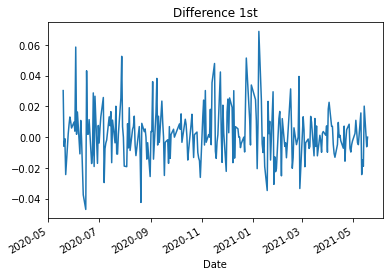

In [19]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

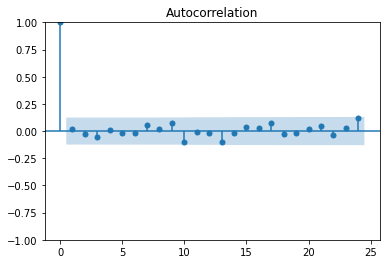

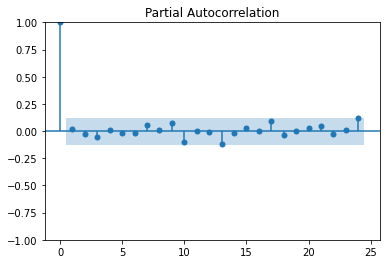

In [20]:
plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


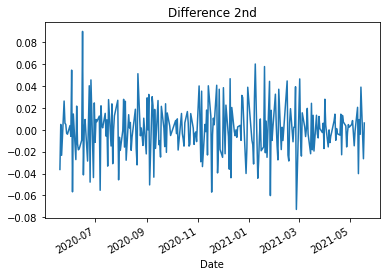

In [21]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

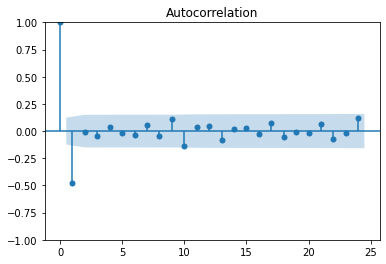

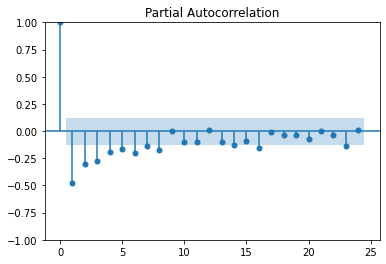

In [22]:
plot_acf(diff_2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

<AxesSubplot:title={'center':'Difference 2nd'}, xlabel='Date'>

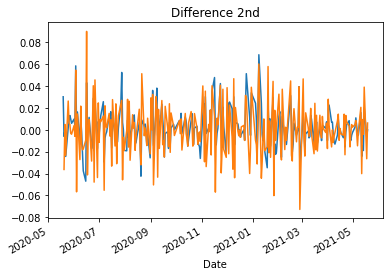

In [23]:
diff_1.plot(title='Difference 1st')
diff_2.plot(title='Difference 2nd')

In [ ]:
1차가 더 나은 결과를 보여준다

### STEP 6 : ARIMA 모델 훈련과 테스트

- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)

1차 차분을 한 데이터의 경우, 모두 금방 0에 수렴하고, 대부분의 데이터들이 파란 범주 안에 포함되는 것을 확인
따라서, ARIMA의 p = 1, q = 1, d = 0 설정완료

In [24]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = sm.tsa.arima.ARIMA(train_data, order=(1,1,0))
fitted_m = model.fit()
print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 583.488
Date:                Thu, 17 Feb 2022   AIC                          -1162.976
Time:                        08:21:00   BIC                          -1156.153
Sample:                             0   HQIC                         -1160.222
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0333      0.061      0.545      0.586      -0.086       0.153
sigma2         0.0003   2.42e-05     13.219      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-

In [25]:
# 모델 테스트 및 플로팅

import pandas as pd

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

NameError: name 'conf' is not defined

NameError: name 'conf' is not defined 

의문이다...

In [26]:
# 로그 변환한 값을 다시 지수 변환

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3480513.747715865
MAE:  1403.033723618997
RMSE:  1865.6135043775453
MAPE: 1.74%


# GOOD

## STEP 7 : 다른 주식 종목 예측해 보기

### (1)TSLA 1y

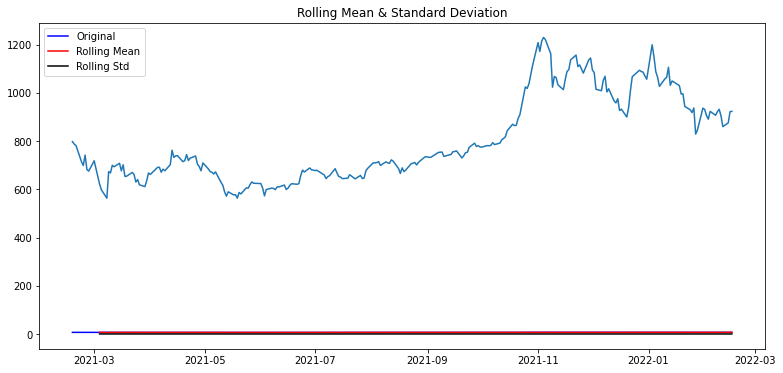

Results of Dickey-Fuller Test:
Test Statistic                  -1.253137
p-value                          0.650330
#Lags Used                       0.000000
Number of Observations Used    253.000000
Critical Value (1%)             -3.456464
Critical Value (5%)             -2.873033
Critical Value (10%)            -2.572895
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.567501e+00
p-value                        8.089813e-09
#Lags Used                     7.000000e+00
Number of Observations Used    2.160000e+02
Critical Value (1%)           -3.460992e+00
Critical Value (5%)           -2.875016e+00
Critical Value (10%)          -2.573952e+00
dtype: float64


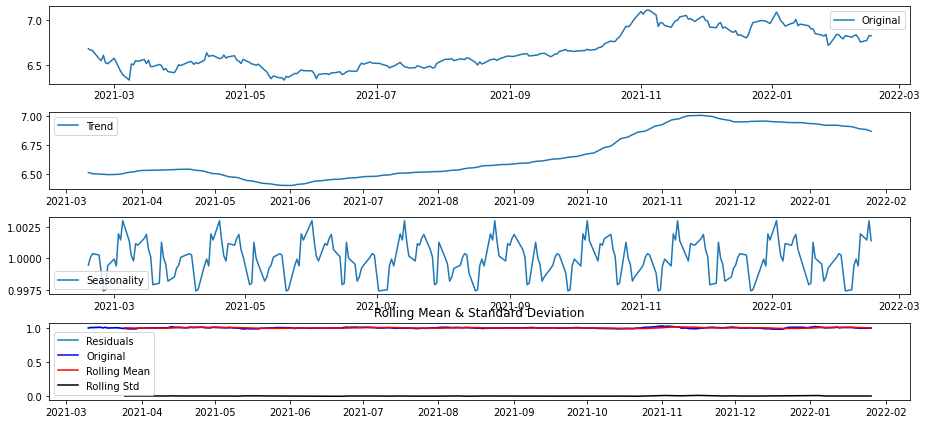

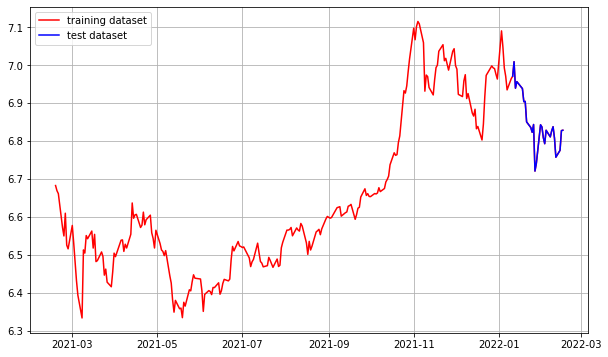

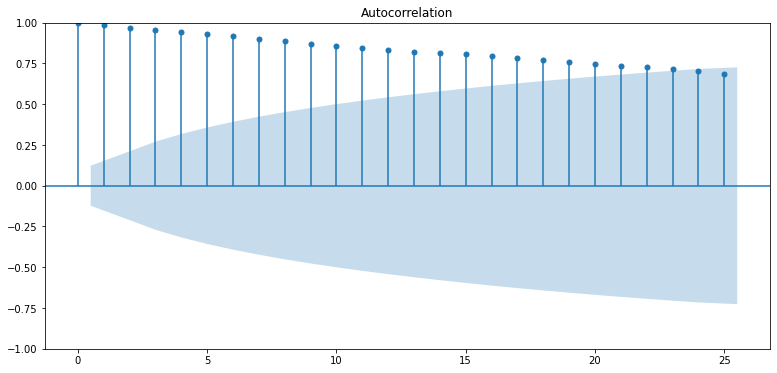

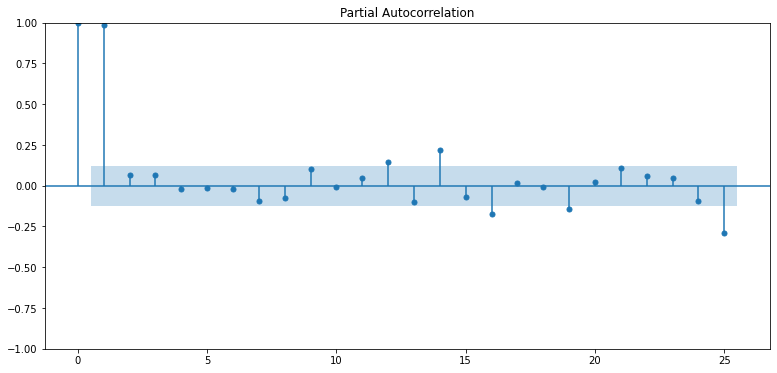

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/EXPLORATIONS/EX_11/stock_prediction/data/TSLA.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()


from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.


# 로그 변환
ts_log = np.log(ts)


# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
    
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)


plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)


train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

ADF test에서의 p-value 값은 0.650330/ residual의 p-value는 8.089813e-09로 높은값

Results of Dickey-Fuller Test:
Test Statistic                -1.683248e+01
p-value                        1.155026e-29
#Lags Used                     0.000000e+00
Number of Observations Used    2.520000e+02
Critical Value (1%)           -3.456569e+00
Critical Value (5%)           -2.873079e+00
Critical Value (10%)          -2.572919e+00
dtype: float64


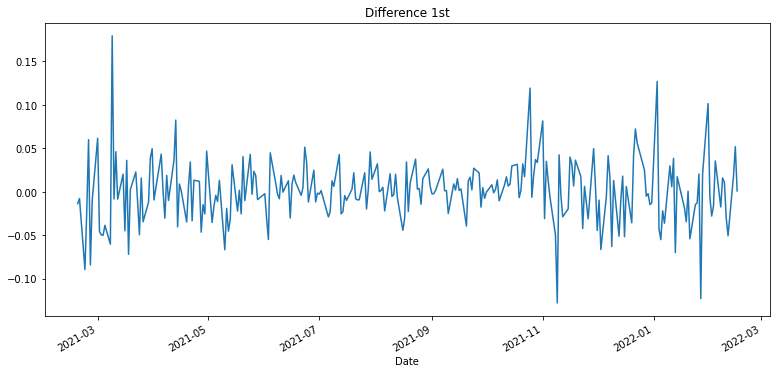

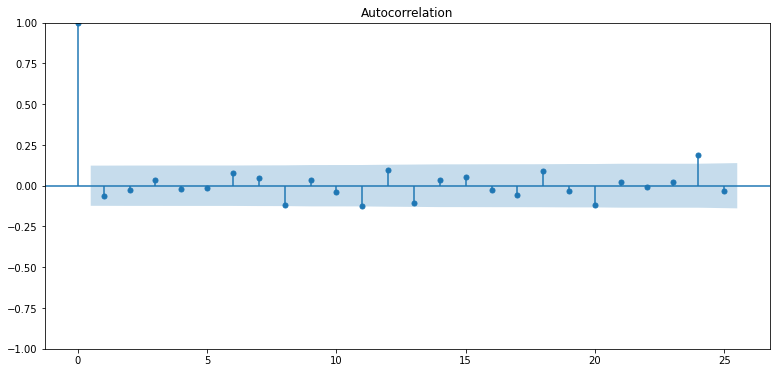

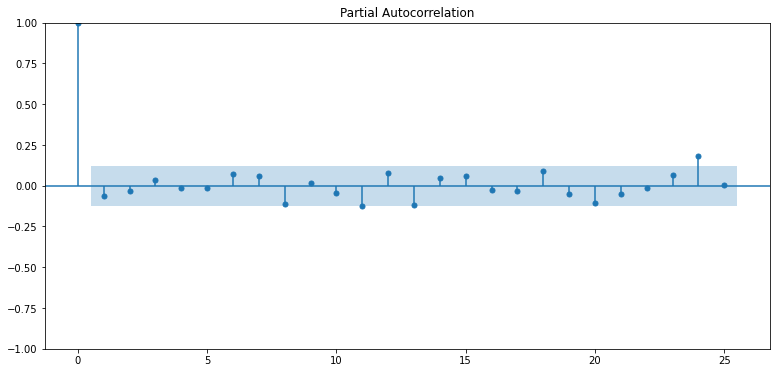

Results of Dickey-Fuller Test:
Test Statistic                -7.198159e+00
p-value                        2.404162e-10
#Lags Used                     1.600000e+01
Number of Observations Used    2.350000e+02
Critical Value (1%)           -3.458487e+00
Critical Value (5%)           -2.873919e+00
Critical Value (10%)          -2.573367e+00
dtype: float64


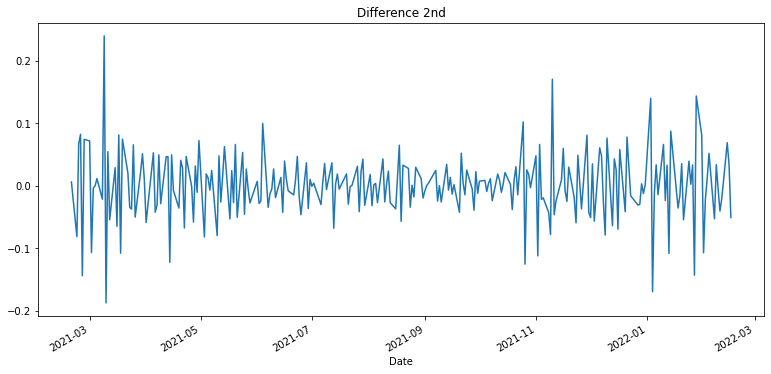

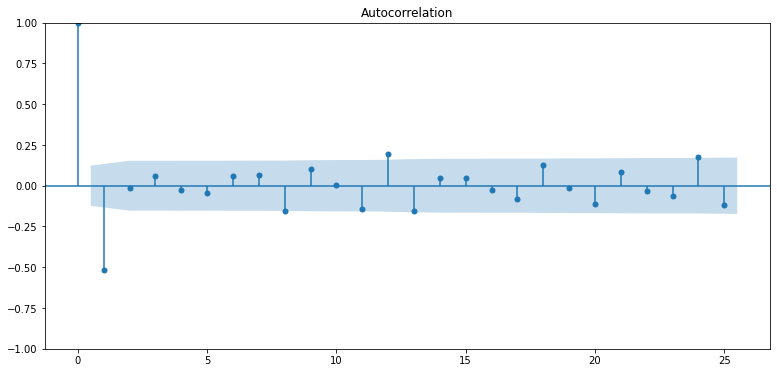

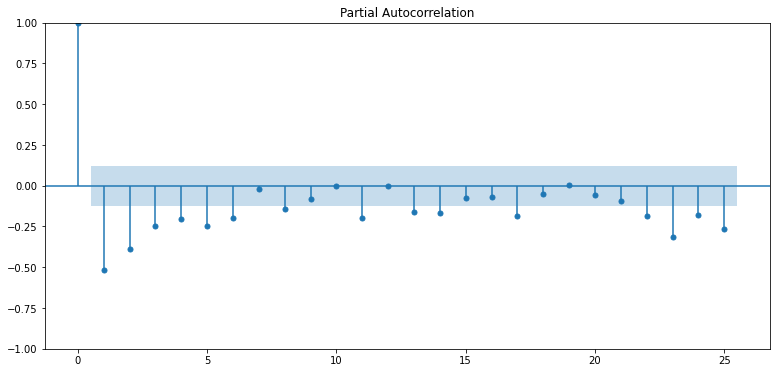

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 434.073
Date:                Thu, 17 Feb 2022   AIC                           -862.145
Time:                        08:46:10   BIC                           -851.884
Sample:                             0   HQIC                          -858.004
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0531      0.067     -0.788      0.431      -0.185       0.079
ma.L1         -0.9900      0.014    -69.505      0.000      -1.018      -0.962
sigma2         0.0012   6.37e-05     19.384      0.0

In [42]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')
augmented_dickey_fuller_test(diff_2)

plot_acf(diff_2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = sm.tsa.arima.ARIMA(train_data, order=(1,2,1))
fitted_m = model.fit()
print(fitted_m.summary())

In [43]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

NameError: name 'conf' is not defined

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  27403.031693289933
MAE:  148.49886901410036
RMSE:  165.53861088365437
MAPE: 16.34%


- p=1, d=1, q=0 -> MAPE: 13.00%
- p=1, d=1, q=1 -> MAPE: 13.01%
- q=1, d=2, q=0 -> MAPE: 23.61%
- q=1, d=2, q=1 -> MAPE: 16.34%
    
역시 첫 시도인 1,1,0 => MAPE 13%가 제일 낫다

### (2) Bitcoin USD (BTC-USD) 1y

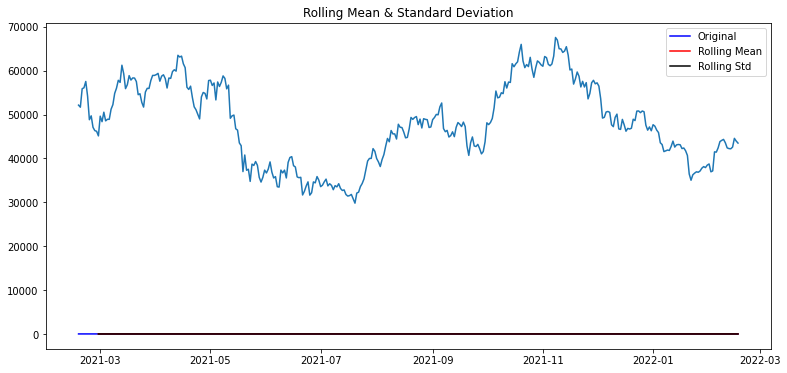

Results of Dickey-Fuller Test:
Test Statistic                  -1.890047
p-value                          0.336758
#Lags Used                       0.000000
Number of Observations Used    365.000000
Critical Value (1%)             -3.448394
Critical Value (5%)             -2.869491
Critical Value (10%)            -2.571006
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -6.106679e+00
p-value                        9.547602e-08
#Lags Used                     9.000000e+00
Number of Observations Used    3.260000e+02
Critical Value (1%)           -3.450569e+00
Critical Value (5%)           -2.870447e+00
Critical Value (10%)          -2.571515e+00
dtype: float64


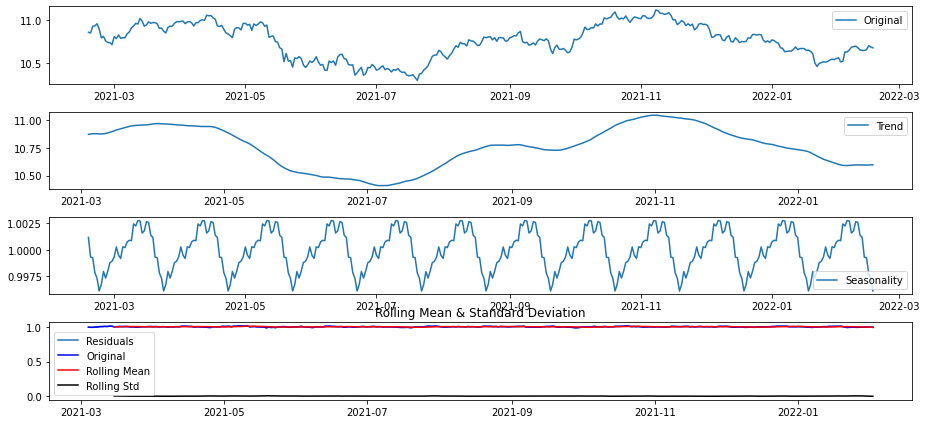

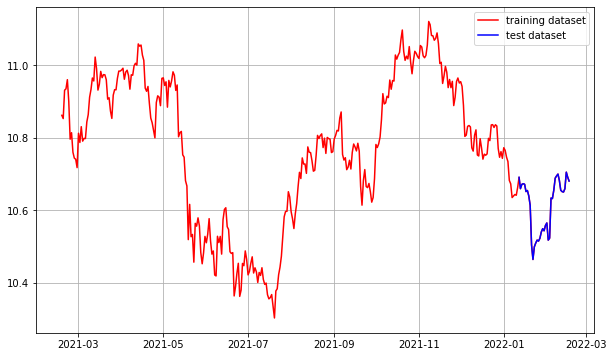

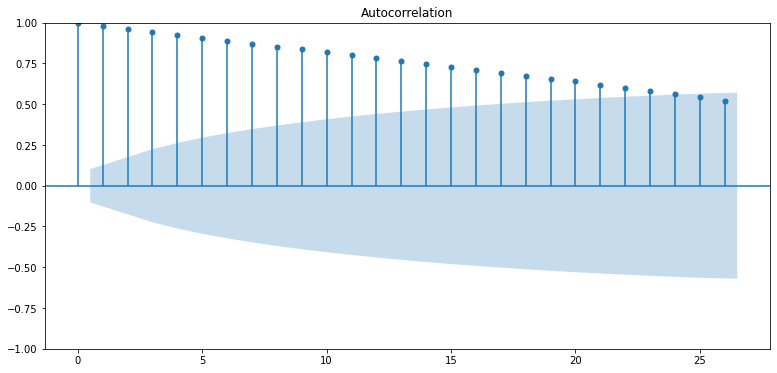

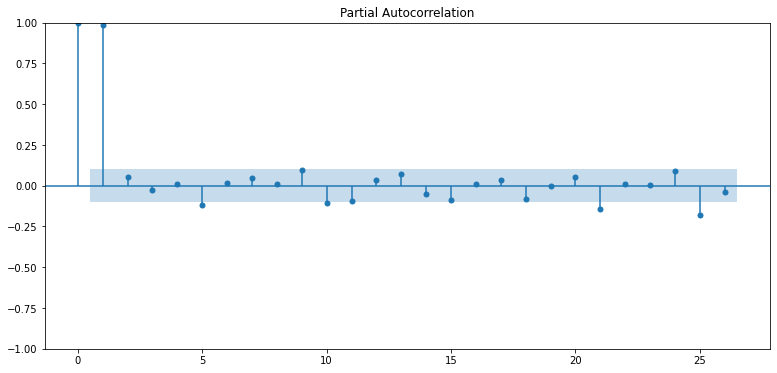

In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/EXPLORATIONS/EX_11/stock_prediction/data/BTC-USD.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()


from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.


# 로그 변환
ts_log = np.log(ts)


# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
    
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)


plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)


train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

In [ ]:
ADF test에서의 p-value 값은  0.336758/ residual의 p-value는 9.547602e-08로 높은값

Results of Dickey-Fuller Test:
Test Statistic                 -20.097093
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


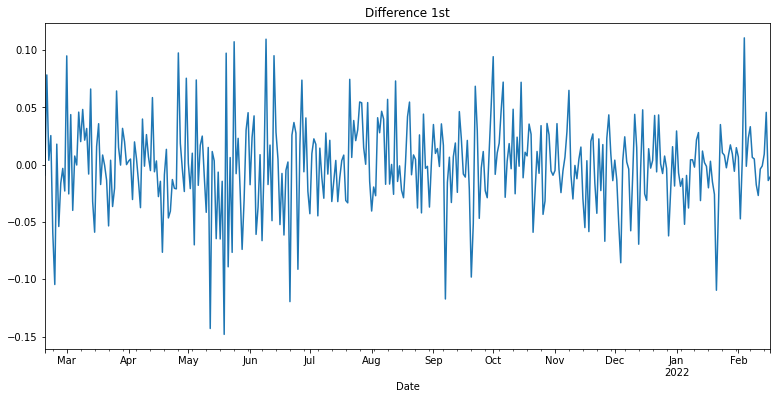

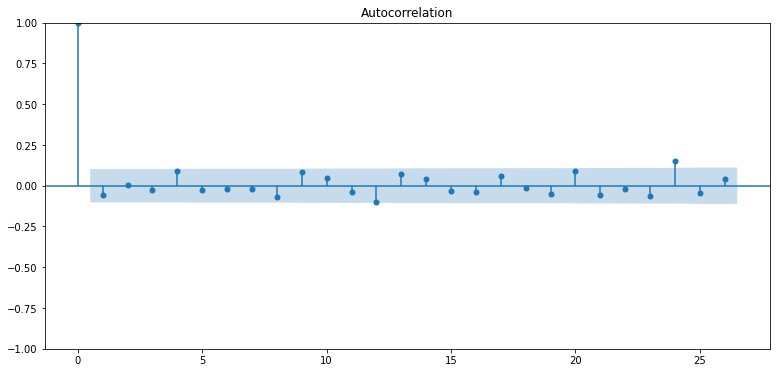

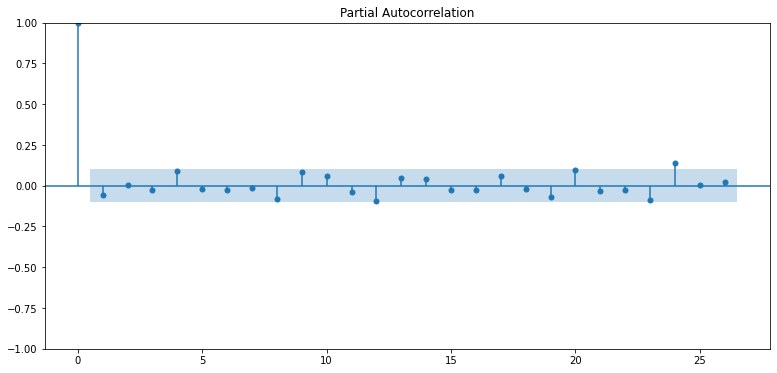

Results of Dickey-Fuller Test:
Test Statistic                -9.122743e+00
p-value                        3.172792e-15
#Lags Used                     1.200000e+01
Number of Observations Used    3.510000e+02
Critical Value (1%)           -3.449119e+00
Critical Value (5%)           -2.869810e+00
Critical Value (10%)          -2.571176e+00
dtype: float64


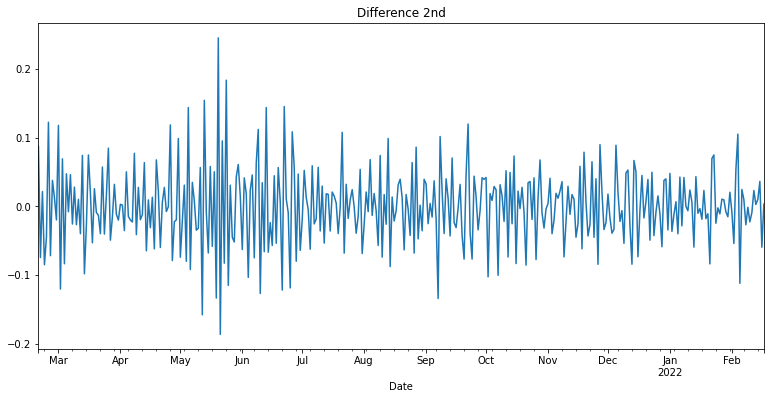

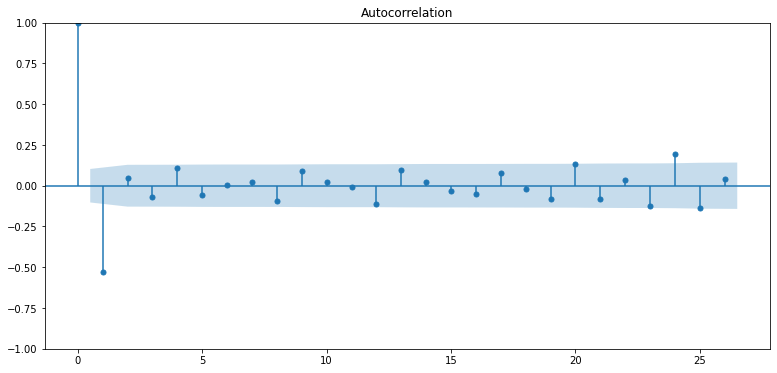

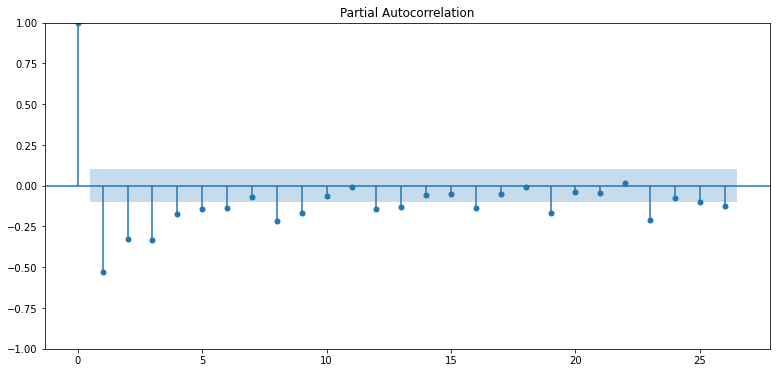

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  329
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 596.764
Date:                Thu, 17 Feb 2022   AIC                          -1189.529
Time:                        08:52:42   BIC                          -1181.943
Sample:                    02-17-2021   HQIC                         -1186.502
                         - 01-11-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0734      0.057     -1.288      0.198      -0.185       0.038
sigma2         0.0015   9.53e-05     16.154      0.000       0.001       0.002
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [58]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')
augmented_dickey_fuller_test(diff_1)

plot_acf(diff_1)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_1)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()


diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')
augmented_dickey_fuller_test(diff_2)

plot_acf(diff_2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(diff_2)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = sm.tsa.arima.ARIMA(train_data, order=(1,1,0))
fitted_m = model.fit()
print(fitted_m.summary())

In [59]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

NameError: name 'conf' is not defined

In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  12389612.121601805
MAE:  2604.4165750062116
RMSE:  3519.8880836756452
MAPE: 6.84%


In [ ]:
- p=1, d=1, q=0 -> MAPE: 6.84%
- p=1, d=1, q=1 -> MAPE: 6.86%
- q=1, d=2, q=0 -> MAPE: 36.43%
- q=1, d=2, q=1 -> MAPE: 6.71%
    
왜 1,2,0 일때만 36%인걸까 어떤 영향이지?

### (3) FB 1y

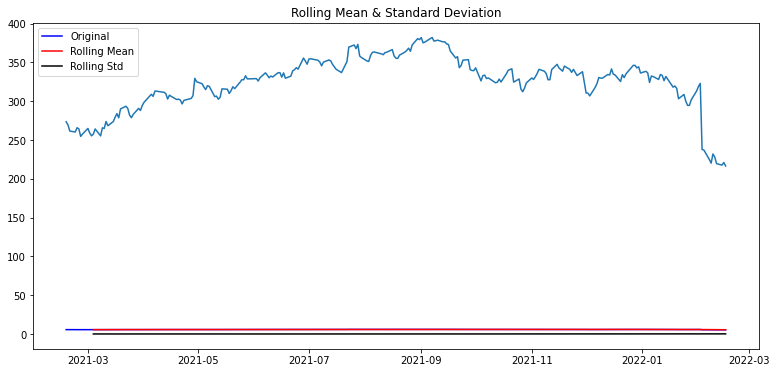

Results of Dickey-Fuller Test:
Test Statistic                  -0.233931
p-value                          0.934354
#Lags Used                       4.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                  -5.352033
p-value                          0.000004
#Lags Used                       5.000000
Number of Observations Used    218.000000
Critical Value (1%)             -3.460708
Critical Value (5%)             -2.874891
Critical Value (10%)            -2.573886
dtype: float64


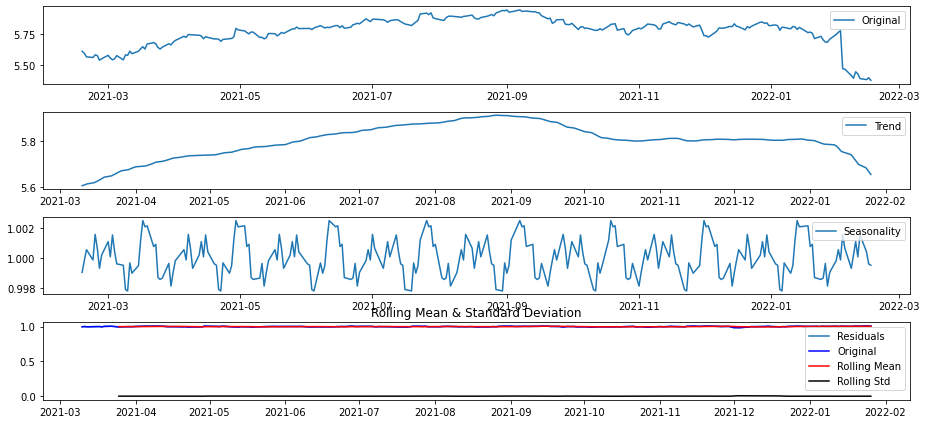

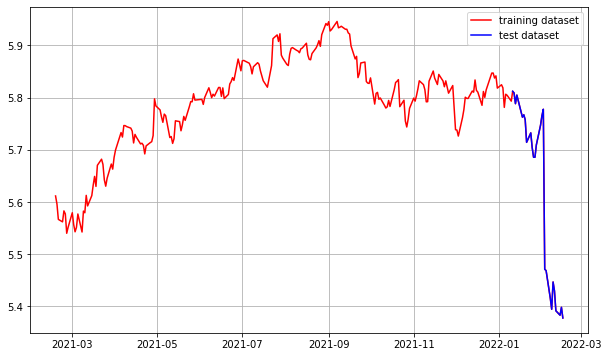

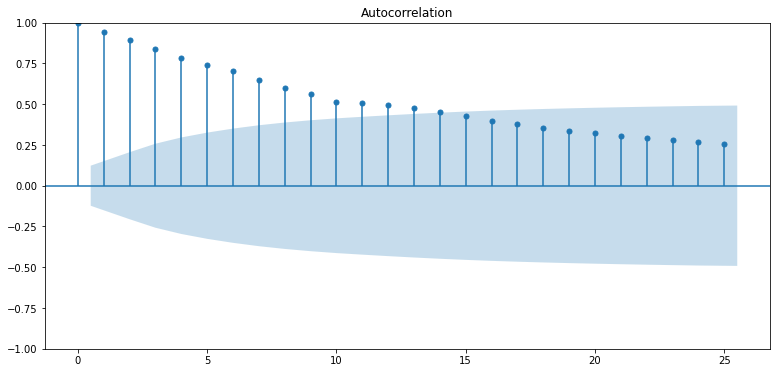

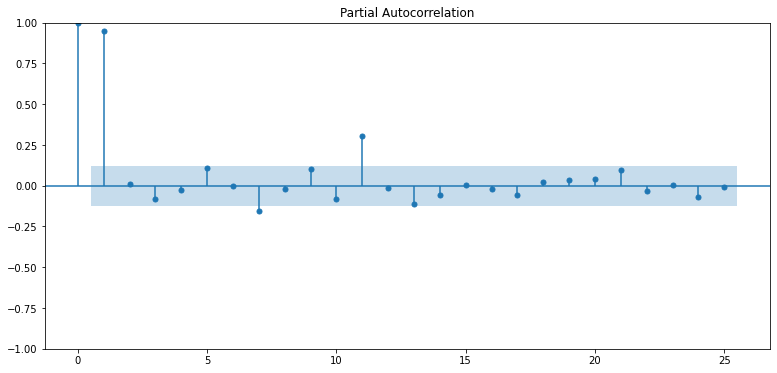

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  228
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 583.704
Date:                Thu, 17 Feb 2022   AIC                          -1161.409
Time:                        09:11:34   BIC                          -1151.134
Sample:                             0   HQIC                         -1157.263
                                - 228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1261      0.840      0.150      0.881      -1.521       1.773
ma.L1         -0.2031      0.839     -0.242      0.809      -1.848       1.441
sigma2         0.0003   2.74e-05     12.459      0.0

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/EXPLORATIONS/EX_11/stock_prediction/data/FB.csv' 
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()


from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts)

# 결측치 처리
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.


# 로그 변환
ts_log = np.log(ts)


# 일정 시간 내 구간 통계치(Rolling Statistics)를 시각화하는 함수
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
    
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


# Residual 안정성 확인
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)


plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)


train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = sm.tsa.arima.ARIMA(train_data, order=(1,1,1))
fitted_m = model.fit()
print(fitted_m.summary())

In [68]:
ADF test에서의 p-value 값은 0.934354/ residual의 p-value는 0.000004

SyntaxError: invalid syntax (2990870447.py, line 1)

In [ ]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1797084415.949501
MAE:  42392.00845547016
RMSE:  42392.032458346475
MAPE: 15539.70%


오 이런 데이터는 mape이 15539.70%가 나온다

### trial and error

시계열 분석은 마침 개인적으로 공부하고 있는 부분과 맞닿아있어서 잘 해야할 노드였다. 변명이지만 여러 이유로 당일날 처음 보게되었고 
p-value를 비롯한 다양한 통계적 지식 공부가 필요함을 느꼈다. 노드를 하나씩 진행할 수록 부족한 부분이 늘어나고 뭔가 더 구렁텅이로 빠지는 느낌이지만 하나씩 다시 마음 잡고 해봐야지 ! :)